# A Pillow Test

The previous thing used Matplotlib to render the final image, which has it's own performance quirks. This time we will try to use Pillow instead, since this is now less a data visualization thing and more of a computer graphics thing, and therefore will afford us greater control over the final rendered image.

We will be doing almost exactly the same thing as before (slightly optimized escape time algorithm), but with Pillow instead.



In [1]:
import numpy as np

class Pixel:
    """
    A class to manage Pixel properties
    """
    def __init__(self, x, y, color):
        self.x = x
        self.y = y
        self.color = color

def rescale(number, width, min_val, max_val):
    """
    A function to rescale values based on resolutions
    """
    return (max_val-min_val)*number/width + min_val

# here, we are only implementing the optimized-ish algorithm

def optimized_escape_time_alogrithm(x_width, y_width):
	xs = np.arange(0,x_width)
	ys = np.arange(0,y_width)

	screen = np.asarray([[Pixel(x, y, 0) for x in xs] for y in ys]).flatten()
	for pixel in screen:
		x0 = rescale(pixel.x, x_width, -2.00, 0.47)
		y0 = rescale(pixel.y, y_width, -1.12, 1.12)
		x = 0
		y = 0
		iteration = 0
		max_iter = 1000

		x2 = 0
		y2 = 0
		while ((x2 + y2 <= 4) and (iteration < max_iter)):
			y = 2 * x * y + y0
			x = x2 - y2 + x0
			x2 = x * x
			y2 = y * y
			iteration += 1
		pixel.color = iteration
	
	pixel_color = [pixel.color for pixel in screen]
	reshaped_screen = np.reshape(pixel_color, (x_width,y_width))

	return reshaped_screen

In [2]:
# now we do the pillow shit

from PIL import Image

width = 200
height = 200

generated_fractal_array = optimized_escape_time_alogrithm(width, height)



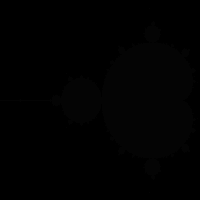

In [3]:
img = Image.fromarray(generated_fractal_array)
img

This of course is a little bit dull, because the colours are now boring as hell. It needs to be mapped onto a colour spectrum of sorts. Running `img.mode` gives us the color mode it uses, which appears to be `I`, which is a 32-bit signed integer pixel. We need to change this using a color map of some kind.

To do this, we will employ HSV counting. The way we will employ this is by taking the `iter_count` of each pixel, and rescale it within 0 and `max_iter` to 0 and 360 (luckily, we have a rescale function that can help us with that).

$$
\begin{align}
h &= \left(\frac{i}{\text{max}_i}\times 360\right)^{1.5}\\
s &= 100\\
v &= \frac{i}{\text{max}_i} \times 100
\end{align}
$$

We can change $s$ to 50 to decrease saturation if we want. Additionally, we can offer other color maps, should we be interested in that, such as LCH colouring.

To do this efficiently, we will perform the transformation on the array itself, and then while converting the array into an image, we will assign the appropriate color mode.

In [4]:
max_iter = 1000

In [5]:
iter_vals_flattened = generated_fractal_array.flatten()
hue_vals = ((iter_vals_flattened/max_iter * 360)**1.5)%360
sat_vals = np.ones(hue_vals.shape)*100
val_vals = iter_vals_flattened/max_iter * 100

In [6]:
hsv_vals = np.dstack((hue_vals, sat_vals, val_vals))
print(hsv_vals.shape)
print(hsv_vals[0][0])


(1, 40000, 3)
[  0.216 100.      0.1  ]


In [7]:
hsv_vals = hsv_vals.reshape((*generated_fractal_array.shape, 3))

hsv_vals = hsv_vals.astype('uint8')
print(hsv_vals)


[[[  0 100   0]
  [  0 100   0]
  [  0 100   0]
  ...
  [  0 100   0]
  [  0 100   0]
  [  0 100   0]]

 [[  0 100   0]
  [  0 100   0]
  [  0 100   0]
  ...
  [  0 100   0]
  [  0 100   0]
  [  0 100   0]]

 [[  0 100   0]
  [  0 100   0]
  [  0 100   0]
  ...
  [  0 100   0]
  [  0 100   0]
  [  0 100   0]]

 ...

 [[  0 100   0]
  [  0 100   0]
  [  0 100   0]
  ...
  [  0 100   0]
  [  0 100   0]
  [  0 100   0]]

 [[  0 100   0]
  [  0 100   0]
  [  0 100   0]
  ...
  [  0 100   0]
  [  0 100   0]
  [  0 100   0]]

 [[  0 100   0]
  [  0 100   0]
  [  0 100   0]
  ...
  [  0 100   0]
  [  0 100   0]
  [  0 100   0]]]


In [8]:
Image.fromarray(hsv_vals, mode="HSV").show()

Of course, I have now discovered the hard way that PIL doesn't like anything that is not a `uint8`, meaning if I provide a hue value that's above 255, it starts freaking out. As a consequence, I have to, yes you heard that right, rescale it to 255.

I'm not going to change any of the above code per se, I'm just going to do some additional tests, in some sense.

Update : I fucking hate everything, _everything_ needs to be rescaled to 255. aaAAAA.

In [9]:
# first, we will rescale it while already mapping the iteration numbers to the final values

iter_vals_flattened = generated_fractal_array.flatten()
hue_vals = ((iter_vals_flattened/max_iter * 255)**1.5)%255
sat_vals = np.ones(hue_vals.shape)*255
val_vals = iter_vals_flattened/max_iter * 255

hsv_vals = np.dstack((hue_vals, sat_vals, val_vals)).reshape((*generated_fractal_array.shape, 3)).astype("uint8")

img = Image.fromarray(hsv_vals, mode="HSV")

img.show()

# it works as expected, I guess, I just don't like it that much lol.

In [10]:
# anyway, just to encapsulate all of this into a function

def convert2HSV(arr):
    """
    Takes in an array and maps the iteration values to some HSV
    value, as determined by the exponential mapping formula.
    
	Takes in an array, returns an array
    """
    iter_vals_flattened = arr.flatten()
    hue_vals = ((arr/max_iter * 255)**1.5)%255
    sat_vals = np.ones(hue_vals.shape)*255
    val_vals = arr/max_iter * 255
    hsv_vals = np.dstack((hue_vals, sat_vals, val_vals)).reshape((*arr.shape, 3)).astype("uint8")
    return hsv_vals


    


In [11]:
# so, our overall procedure now is
import time
width = 100
height = 100

start = time.time_ns()

raw_array = optimized_escape_time_alogrithm(width, height)
print(raw_array.shape)

end = time.time_ns()

print(f"Generating the fractal took {(end-start)*1e-9:1.3e}s")

start = time.time_ns()
hsv_array = convert2HSV(raw_array)
end = time.time_ns()

print(f"Converting values to HSV took {(end-start)*1e-9:1.3e}s")
# produce the HSV fractal

start = time.time_ns()

hsv_img = Image.fromarray(hsv_array, mode="HSV")

# display the image
hsv_img.show()
end = time.time_ns()

print(f"Converting array to image and displaying took {(end-start)*1e-9:1.3e}s")



(100, 100)
Generating the fractal took 9.443e+00s
Converting values to HSV took 2.227e-03s
Converting array to image and displaying took 2.016e+00s


As can be seen above, the new operations add an overhead of ~1.7 seconds for a 1920x1920 picture, which is remarkably fast in some sense of speaking. It still doesn't look very amazing, but it's a good thing we've already in some sense implemented our color scheme tasks.